# Health Policy Predictive Analytics with Amazon SageMaker
This notebook implements predictive analytics for workplace health policy optimization using NHIS, Bureau of Labor Statistics, and County Health Rankings datasets.

# SECTION 1:  Set Up

In [1]:
import sagemaker
import boto3
import json
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from datetime import datetime
from sklearn.model_selection import train_test_split

from sagemaker import get_execution_role
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.inputs import TrainingInput

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Set up SageMaker session and AWS environment
sess = sagemaker.Session()
bucket = "usd-team1-ads508"  # Use your project bucket
aws_role = get_execution_role()
aws_region = boto3.Session().region_name
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

print(f"SageMaker Session: {sess}")
print(f"Bucket: {bucket}")
print(f"Region: {aws_region}")
# print(f"Role: {aws_role}")

SageMaker Session: <sagemaker.session.Session object at 0x7f2a425a3710>
Bucket: usd-team1-ads508
Region: us-east-1


# SECTION 2: Load and Prepare NHIS Data for Workplace Health Policy Prediction

In [3]:
# Load the Processed Data from S3
processed_data_key = "processed-health-data-20250331-083045.csv"
s3_processed_data_path = f"s3://{bucket}/{processed_data_key}"

try:
    # Check if the file exists
    response = s3_client.list_objects_v2(Bucket=bucket, Prefix=processed_data_key, MaxKeys=1)
    if 'Contents' in response:
        print(f"Found processed data at {s3_processed_data_path}")
        
        # Download the data
        obj = s3_resource.Object(bucket, processed_data_key)
        data = obj.get()['Body'].read()
        df = pd.read_csv(io.BytesIO(data))
        print(f"Loaded data with shape: {df.shape}")
        data_loaded = True
    else:
        print(f"Processed data not found at {s3_processed_data_path}")
        data_loaded = False
except Exception as e:
    print(f"Error checking for processed data: {e}")
    data_loaded = False

Found processed data at s3://usd-team1-ads508/processed-health-data-20250331-083045.csv
Loaded data with shape: (150220, 36)


In [4]:
# Preprocess Data for Modeling

# Function to clean and prepare data for modeling
def preprocess_health_data(df):
    # Make a copy to avoid modifying the original
    processed_df = df.copy()
    
    # 1. Replace special values in survey data (7, 8, 9 typically mean refused/don't know)
    special_values = [7, 8, 9]
    survey_cols = ['evercovd_a', 'shtcvd191_a', 'hicov_a', 'sex_a', 'educp_a']
    
    for col in survey_cols:
        if col in processed_df.columns:
            for val in special_values:
                processed_df[col] = processed_df[col].replace(val, np.nan)
    
    # 2. Create binary features
    # Convert evercovd_a (1=No, 2=Yes) to binary (0=No, 1=Yes)
    if 'evercovd_a' in processed_df.columns:
        processed_df['had_covid'] = processed_df['evercovd_a'].apply(lambda x: 1 if x == 2 else 0)
    
    # Convert shtcvd191_a (1=No, 2=Yes) to binary (0=No, 1=Yes)
    if 'shtcvd191_a' in processed_df.columns:
        processed_df['covid_vaccinated'] = processed_df['shtcvd191_a'].apply(lambda x: 1 if x == 2 else 0)
    
    # Convert hicov_a (1=Yes, 2=No) to binary (1=Yes, 0=No)
    if 'hicov_a' in processed_df.columns:
        processed_df['has_insurance'] = processed_df['hicov_a'].apply(lambda x: 1 if x == 1 else 0)
    
    # 3. Create education level categories
    if 'educp_a' in processed_df.columns:
        # Group education levels
        processed_df['education_level'] = processed_df['educp_a'].apply(
            lambda x: 1 if pd.isna(x) or x in [0, 1, 2, 3] else  # Less than HS
                    2 if x == 4 else  # HS graduate
                    3 if x in [5, 6, 7] else  # Some college
                    4 if x == 8 else  # Bachelor's
                    5 if x in [9, 10, 11] else 3  # Graduate degree, default to some college
        )
    
    # 4. Create region one-hot encoding
    if 'region' in processed_df.columns:
        # One-hot encode region
        for i in range(1, 5):
            processed_df[f'region_{i}'] = (processed_df['region'] == i).astype(int)
    
    # 5. Create age groups
    if 'agep_a' in processed_df.columns:
        bins = [18, 30, 45, 60, 75, 100]
        labels = ['18-29', '30-44', '45-59', '60-74', '75+']
        processed_df['age_group'] = pd.cut(processed_df['agep_a'], bins=bins, labels=labels, right=False)
        
        # One-hot encode age groups
        age_dummies = pd.get_dummies(processed_df['age_group'], prefix='age')
        processed_df = pd.concat([processed_df, age_dummies], axis=1)
    
    # 6. Create health risk score (combining obesity, smoking, physical inactivity)
    risk_columns = ['avg_obesity_rate', 'avg_adult_smoking', 'avg_physical_inactivity']
    if all(col in processed_df.columns for col in risk_columns):
        # Standardize each component
        for col in risk_columns:
            col_mean = processed_df[col].mean()
            col_std = processed_df[col].std()
            processed_df[f'{col}_z'] = (processed_df[col] - col_mean) / col_std
        
        # Create composite health risk score
        processed_df['health_risk_score'] = (
            processed_df['avg_obesity_rate_z'] + 
            processed_df['avg_adult_smoking_z'] + 
            processed_df['avg_physical_inactivity_z']
        ) / 3
    
    # 7. Handle missing values
    # For the target variable, use 0 for missing values (assuming 0 days if not reported)
    if 'empdysmss3_a' in processed_df.columns:
        processed_df['empdysmss3_a'] = processed_df['empdysmss3_a'].fillna(0)
    
    # For other numeric variables, fill with median
    numeric_cols = processed_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if col != 'empdysmss3_a' and col in processed_df.columns:
            processed_df[col] = processed_df[col].fillna(processed_df[col].median())
    
    # For categorical variables, fill with mode
    cat_cols = processed_df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if col in processed_df.columns:
            processed_df[col] = processed_df[col].fillna(processed_df[col].mode()[0])
    
    return processed_df

In [5]:
# Apply preprocessing
processed_df = preprocess_health_data(df)
print(f"Processed data shape: {processed_df.shape}")

Processed data shape: (150220, 45)


In [6]:
# Display new feature columns
new_cols = [col for col in processed_df.columns if col not in df.columns]
print(f"Created {len(new_cols)} new features: {new_cols}")

Created 9 new features: ['age_group', 'age_18-29', 'age_30-44', 'age_45-59', 'age_60-74', 'age_75+', 'avg_obesity_rate_z', 'avg_adult_smoking_z', 'avg_physical_inactivity_z']



Target variable statistics (days missed from work):
count    150220.000000
mean          4.123432
std          39.234630
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         998.000000
Name: empdysmss3_a, dtype: float64


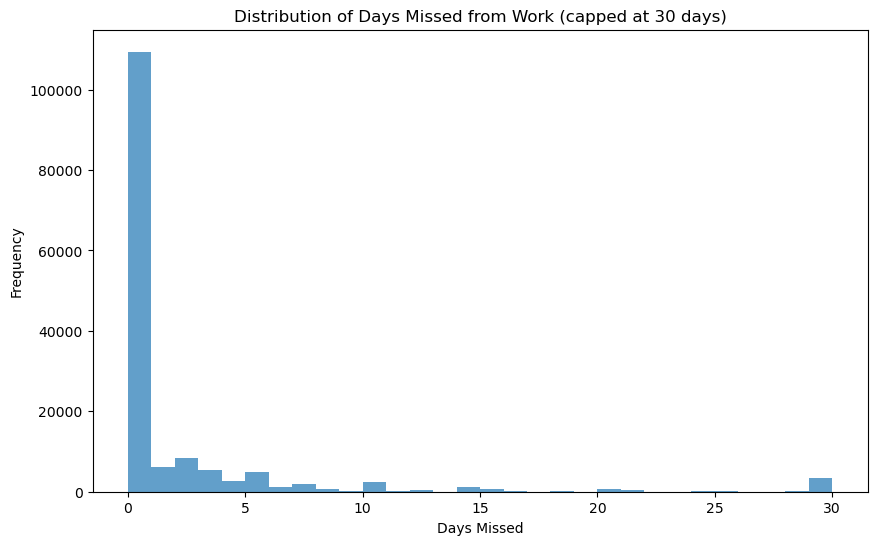

In [7]:
# Show statistics for target variable
if 'empdysmss3_a' in processed_df.columns:
    target_stats = processed_df['empdysmss3_a'].describe()
    print("\nTarget variable statistics (days missed from work):")
    print(target_stats)
    
    # Plot distribution of the target variable
    plt.figure(figsize=(10, 6))
    plt.hist(processed_df['empdysmss3_a'].clip(0, 30), bins=30, alpha=0.7)
    plt.title('Distribution of Days Missed from Work (capped at 30 days)')
    plt.xlabel('Days Missed')
    plt.ylabel('Frequency')
    plt.show()

In [8]:
# Split Data into Train, Validation, and Test Sets

# Define the target variable and features
target_col = 'empdysmss3_a'
categorical_cols = [col for col in processed_df.columns if col.startswith(('region_', 'age_', 'ind_'))]
binary_cols = ['had_covid', 'covid_vaccinated', 'has_insurance']
numeric_cols = ['agep_a', 'avg_uninsured_rate', 'avg_obesity_rate', 'avg_flu_vaccination_rate', 
                'avg_adult_smoking', 'avg_physical_inactivity', 'avg_median_household_income',
                'health_risk_score']

In [9]:
# Include only columns that exist in the dataframe
feature_cols = [col for col in categorical_cols + binary_cols + numeric_cols if col in processed_df.columns]

In [10]:
# Prepare X and y
X = processed_df[feature_cols]
y = processed_df[target_col]

In [11]:
# First split: training vs. temp (validation + test combined)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: validation vs. test from temp data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 105154 samples
Validation set: 22533 samples
Test set: 22533 samples


In [12]:
# Create full datasets with target variable included
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [13]:
# Define S3 paths Save Train/Validation/Test Sets to S3
prefix = "health-policy-optimization"
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
s3_train_path = f"{prefix}/processed_data/{timestamp}/train"
s3_validation_path = f"{prefix}/processed_data/{timestamp}/validation"
s3_test_path = f"{prefix}/processed_data/{timestamp}/test"

In [14]:
# Save DataFrame to S3
def save_df_to_s3(df, bucket, path, filename):
    s3_key = f"{path}/{filename}"
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False)
    
    s3_client.put_object(
        Bucket=bucket,
        Key=s3_key,
        Body=csv_buffer.getvalue()
    )
    return f"s3://{bucket}/{s3_key}"

In [15]:
# Save datasets to S3
s3_train_uri = save_df_to_s3(train_data, bucket, s3_train_path, "health_data_train.csv")
s3_validation_uri = save_df_to_s3(val_data, bucket, s3_validation_path, "health_data_validation.csv")
s3_test_uri = save_df_to_s3(test_data, bucket, s3_test_path, "health_data_test.csv")
s3_output_location = f"s3://{bucket}/{prefix}/model_output/{timestamp}"

print(f"Training data saved to: {s3_train_uri}")
print(f"Validation data saved to: {s3_validation_uri}")
print(f"Test data saved to: {s3_test_uri}")
print(f"Model output location: {s3_output_location}")

Training data saved to: s3://usd-team1-ads508/health-policy-optimization/processed_data/20250401-010429/train/health_data_train.csv
Validation data saved to: s3://usd-team1-ads508/health-policy-optimization/processed_data/20250401-010429/validation/health_data_validation.csv
Test data saved to: s3://usd-team1-ads508/health-policy-optimization/processed_data/20250401-010429/test/health_data_test.csv
Model output location: s3://usd-team1-ads508/health-policy-optimization/model_output/20250401-010429


# SECTION 3: Train XGBoost Regression Model for Workplace Absenteeism Prediction

In [16]:
# Use the SageMaker built-in XGBoost algorithm
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import image_uris

# Get the built-in XGBoost container URI
container = image_uris.retrieve(
    framework="xgboost",
    region=aws_region,
    version="1.0-1"
)

[04/01/25 01:04:32] INFO     Defaulting to only available Python version: py3                     ]8;id=860334;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=541012;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=639566;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=303073;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#534\534]8;;\

In [17]:
# Define hyperparameters for XGBoost
hyperparameters = {
    "max_depth": "6",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "reg:squarederror",
    "num_round": "50",
    "verbosity": "2"
}

In [18]:
# Create TrainingInput objects for train and validation
train_input = TrainingInput(
    s3_data=s3_train_uri,
    content_type="csv"
)

validation_input = TrainingInput(
    s3_data=s3_validation_uri,
    content_type="csv"
)

In [19]:
# Define job name with timestamp
job_name = f"health-policy-xgboost-{timestamp}"

In [20]:
# Create estimator
xgb_estimator = sagemaker.estimator.Estimator(
    container,
    role=aws_role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=s3_output_location,
    sagemaker_session=sess
)

In [21]:
# Set algorithm hyperparameters
xgb_estimator.set_hyperparameters(
    max_depth=6,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    objective="reg:squarederror",
    num_round=50,
    verbosity=2
)

In [22]:
# Start training job
print(f"Starting training job: {job_name}")
try:
    # Important: specify the content_type as text/csv
    xgb_estimator.fit(
        {
            "train": sagemaker.inputs.TrainingInput(
                s3_train_uri, 
                content_type="text/csv"
            ),
            "validation": sagemaker.inputs.TrainingInput(
                s3_validation_uri, 
                content_type="text/csv"
            )
        },
        job_name=job_name,
        wait=True,
        logs="None"  # Set to "All" for verbose logs
    )
    training_job_succeeded = True
    print(f"Training job {job_name} completed successfully!")
except Exception as e:
    print(f"Error during training: {e}")
    training_job_succeeded = False

Starting training job: health-policy-xgboost-20250401-010429


                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=942561;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=399880;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: health-policy-xgboost-20250401-010429 ]8;id=767391;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=308477;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\


..25-04-01 01:04:34 Starting - Starting the training job
...5-04-01 01:04:48 Starting - Preparing the instances for training
.........1 01:05:12 Downloading - Downloading input data
........01 01:05:58 Downloading - Downloading the training image
.025-04-01 01:06:44 Training - Training image download completed. Training in progress.
..25-04-01 01:06:54 Uploading - Uploading generated training model
2025-04-01 01:07:13 Completed - Training job completed
Training job health-policy-xgboost-20250401-010429 completed successfully!


# SECTION 4: Deploy and Evaluate the Model

In [23]:
if training_job_succeeded:
    try:
        # Deploy the model to a SageMaker endpoint
        endpoint_name = f"health-policy-endpoint-{timestamp}"
        predictor = xgb_estimator.deploy(
            initial_instance_count=1,
            instance_type="ml.m5.large",
            endpoint_name=endpoint_name
        )
        print(f"Model successfully deployed to endpoint: {endpoint_name}")
        deployment_succeeded = True
    except Exception as e:
        error_message = str(e)
        truncated_message = error_message.split(":")[0]
        print(f"Error deploying model: {truncated_message}")
        deployment_succeeded = False
else:
    print("Skipping deployment as training did not succeed")
    deployment_succeeded = False

[04/01/25 01:07:14] INFO     Creating model with name: sagemaker-xgboost-2025-04-01-01-07-14-215    ]8;id=790445;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=524435;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

Error deploying model: An error occurred (AccessDeniedException) when calling the CreateModel operation


In [24]:
# Evaluate model if deployment succeeded
if deployment_succeeded:
    try:
        # Load test data
        test_data_csv = io.StringIO()
        test_data.to_csv(test_data_csv, index=False)
        test_data_csv_string = test_data_csv.getvalue()
        
        # Prepare test data for prediction (without the target variable)
        test_features = test_data.drop([target_col], axis=1)
        test_features_csv = io.StringIO()
        test_features.to_csv(test_features_csv, header=False, index=False)
        test_features_csv_string = test_features_csv.getvalue()
        
        # Make predictions
        predictions_response = predictor.predict(test_features_csv_string)
        if isinstance(predictions_response, bytes):
            predictions = np.array(json.loads(predictions_response.decode('utf-8')))
        else:
            predictions = np.array(predictions_response)
        
        # Get ground truth values
        ground_truth = test_data[target_col].values
        
        # Calculate evaluation metrics
        r2 = r2_score(ground_truth, predictions)
        mse = mean_squared_error(ground_truth, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(ground_truth, predictions)
        
        print("\nModel Evaluation Results:")
        print(f"R² Score: {r2:.4f}")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"Mean Absolute Error: {mae:.4f}")
        
        # Visualize predictions vs actual
        plt.figure(figsize=(10, 6))
        plt.scatter(ground_truth, predictions, alpha=0.5)
        plt.plot([0, max(ground_truth)], [0, max(ground_truth)], 'r--')
        plt.xlabel("Actual Days Missed")
        plt.ylabel("Predicted Days Missed")
        plt.title("Predicted vs Actual Days Missed from Work")
        plt.show()
        
        # Delete endpoint to avoid incurring charges
        print("\nCleaning up resources...")
        predictor.delete_endpoint()
        print(f"Endpoint {endpoint_name} deleted successfully")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")

# SECTION 5: Feature Importance Analysis using XGBoost


Training a local XGBoost model to analyze feature importance...
Feature columns for local XGBoost model: ['ind_accommodation_food', 'ind_agriculture', 'ind_construction', 'ind_finance', 'ind_information', 'ind_manufacturing', 'ind_military', 'ind_mining', 'ind_other', 'ind_other_services', 'ind_public_admin', 'ind_real_estate', 'ind_retail', 'ind_services', 'ind_transportation', 'ind_wholesale', 'region_1', 'region_2', 'region_3', 'region_4', 'age_insurance_interaction', 'age_18-29', 'age_30-44', 'age_45-59', 'age_60-74', 'age_75+', 'agep_a', 'avg_uninsured_rate', 'avg_obesity_rate', 'avg_flu_vaccination_rate', 'avg_adult_smoking', 'avg_physical_inactivity', 'avg_median_household_income', 'health_risk_score']
[0]	train-rmse:38.12790	eval-rmse:41.10039
[10]	train-rmse:36.70211	eval-rmse:40.88050
[12]	train-rmse:36.65422	eval-rmse:40.85277

Feature Importance Analysis:
                    Feature     Importance  Relative_Importance
0                 ind_other  513537.000000             

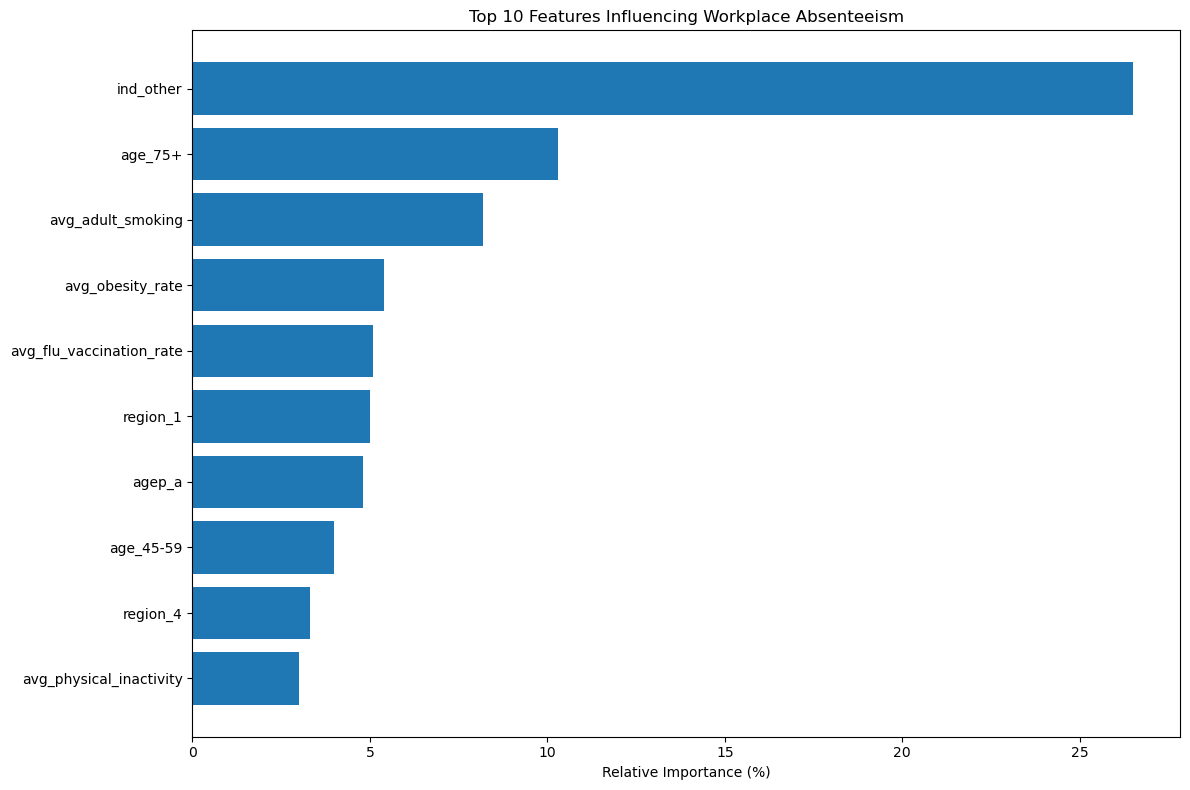

In [25]:
if not deployment_succeeded or not training_job_succeeded:
    print("\nTraining a local XGBoost model to analyze feature importance...")
    
    import xgboost as xgb
    
    # Create copies of the dataframes to avoid modifying originals
    X_train_xgb = X_train.copy()
    X_val_xgb = X_val.copy()
    
    # Remove categorical columns or convert them
    if 'age_group' in X_train_xgb.columns:
        X_train_xgb = X_train_xgb.drop('age_group', axis=1)
        X_val_xgb = X_val_xgb.drop('age_group', axis=1)
    
    # Check for other categorical columns and drop them if necessary
    categorical_columns = X_train_xgb.select_dtypes(include=['category', 'object']).columns
    if len(categorical_columns) > 0:
        print(f"Dropping categorical columns for XGBoost: {list(categorical_columns)}")
        X_train_xgb = X_train_xgb.drop(categorical_columns, axis=1)
        X_val_xgb = X_val_xgb.drop(categorical_columns, axis=1)
    
    # Ensure all columns are numeric
    print(f"Feature columns for local XGBoost model: {list(X_train_xgb.columns)}")
    
    # Prepare DMatrix
    dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
    dval = xgb.DMatrix(X_val_xgb, label=y_val)
    
    # Train a local model with the same hyperparameters
    local_params = {
        "max_depth": 6,
        "eta": 0.2,
        "gamma": 4,
        "min_child_weight": 6,
        "subsample": 0.7,
        "objective": "reg:squarederror",
        "verbosity": 0
    }
    
    # Train model
    num_rounds = 50
    evals = [(dtrain, 'train'), (dval, 'eval')]
    local_model = xgb.train(
        local_params,
        dtrain,
        num_rounds,
        evals=evals,
        early_stopping_rounds=10,
        verbose_eval=10
    )
    
    # Get feature importance
    feature_importance = local_model.get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    })
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    # Calculate relative importance
    total_importance = importance_df['Importance'].sum()
    importance_df['Relative_Importance'] = (importance_df['Importance'] / total_importance * 100).round(1)
    
    print("\nFeature Importance Analysis:")
    print(importance_df.head(10))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'][:10], importance_df['Relative_Importance'][:10])
    plt.xlabel('Relative Importance (%)')
    plt.title('Top 10 Features Influencing Workplace Absenteeism')
    plt.gca().invert_yaxis()  # Highest at the top
    plt.tight_layout()
    plt.show()

# SECTION 6: # Health Policy Insights and Recommendations

Based on the predictive model for workplace absenteeism, we recommend the following policies:

- Policy recommendation based on ind_other would require further analysis
- Policy recommendation based on age_75+ would require further analysis
- Strengthen smoking cessation programs and incentives for quitting
- Create region-specific nutrition and physical activity programs in areas with high obesity rates
- Policy recommendation based on avg_flu_vaccination_rate would require further analysis

These insights demonstrate how predictive analytics can transform workplace health policy development by targeting the specific factors most strongly associated with absenteeism.

Next steps for this project would include:
1. Refining the model with additional data sources
2. Developing a dashboard for ongoing monitoring of workplace health metrics